In [30]:
! pip install scikit-multilearn

## Import Dependencies And Define Paths

In [34]:
import numpy as np 
import pandas as pd 
import os # Path joiner 
from glob import glob # Finds paths specified
# %matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator 
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [2]:
# Define path for the Data_Entry_2017 CSV file 

data = os.path.join("Data_Entry_2017.csv")

## Define Functions

- `plot_distribution()` takes in the value count of labels and displays a bar graph of distribution. 

- `label_encoder()` takes in a df and outputs a new df with encoded values. A separate df is stored as a csv file. 

In [3]:
# Function to plot the distribution of disease labels
# I did not include a return statement since the function returns a duplicate plot with the return statement

def plot_distribution(label_count):
    
    # I have darkmode on my computer so this renders the plot well without cutting out the axes 
    # Comment out and disregard if not necessary 
    plt.style.use('dark_background')

    fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
    ax1.bar(np.arange(len(label_count))+0.5, label_count)
    ax1.set_xticks(np.arange(len(label_count))+0.5)
    ax1.set_xticklabels(label_count.index, rotation = 90)
    

In [4]:
# Function to Encode the Disease Labels from Original df. 

def label_encoder(raw_df, csv_path):
    # Copy the Df into two separate dataframes, one for saving as csv and one for output
    copy_df = raw_df.copy()

    # Split each individual label with a "," not a "|"
    copy_df["Labels List"] = copy_df["Finding Labels"].str.split("|", expand = False)
    
    # Instantiate a MultiLabelBinarizer instance and encode the Finding Labels column store results in separate columns. 
    mlb = MultiLabelBinarizer()
    new_df = pd.DataFrame(mlb.fit_transform(copy_df["Labels List"]),columns=mlb.classes_)

    # Merge the two DF together 
    # Export CSV df 
    encoded_csv_df = pd.concat([copy_df, new_df], axis= 1)

    # Export to csv 
    encoded_csv_df.to_csv(csv_path)

    return encoded_csv_df


## Clean the Data_Entry_2017 File 

- Pair the images in the `Image Index` column with their respective paths. 

- Store the paths in a new column of the dataframe called `path`. 

- Use `map()` to match the correct images to the path.


In [5]:
# Import the Data_Entry_2017.csv file 

all_images_df = pd.read_csv(data)
all_images_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [6]:
# Count the number of total images needed from the data entry file's image index column. 

total_images =  len(all_images_df["Image Index"])

# Get the paths for the images stored in the image files and store them as a dictionary
# Make the keys the image file names using os.path.basename() so it's paired. 
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join("images*", "*", "*.png"))}

# Print results 
print(f"Images found: {len(all_image_paths)} / Total Images: {total_images}")


Images found: 112120 / Total Images: 112120


In [7]:
# Make a new column to store the paths
# Get the values = paths stored in the all_image_paths dictionary by using Image Index column as the key! 
# Check the new column to make sure the index and the paths match. Use Sample to randomly sample across the df. 

all_images_df["path"] = all_images_df["Image Index"].map(all_image_paths.get)
all_images_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
83026,00020407_000.png,No Finding,0,20407,25,F,PA,2694,2518,0.143000,0.143000,NaN,images_009\images\00020407_000.png
72422,00017844_000.png,No Finding,0,17844,26,M,PA,2992,2991,0.143000,0.143000,NaN,images_008\images\00017844_000.png
35075,00009250_000.png,No Finding,0,9250,48,F,PA,2048,2500,0.168000,0.168000,NaN,images_005\images\00009250_000.png
98142,00025911_000.png,No Finding,0,25911,58,M,PA,2021,2021,0.194311,0.194311,NaN,images_011\images\00025911_000.png
38362,00010028_004.png,No Finding,4,10028,60,M,PA,2992,2991,0.143000,0.143000,NaN,images_005\images\00010028_004.png
68179,00016818_000.png,No Finding,0,16818,26,M,AP,2500,2048,0.168000,0.168000,NaN,images_008\images\00016818_000.png
66820,00016508_061.png,Consolidation|Emphysema,61,16508,52,F,AP,2500,2048,0.168000,0.168000,NaN,images_008\images\00016508_061.png
97585,00025758_001.png,No Finding,1,25758,57,M,PA,2992,2991,0.143000,0.143000,NaN,images_011\images\00025758_001.png
66075,00016331_000.png,Mass,0,16331,78,F,PA,2782,2901,0.143000,0.143000,NaN,images_008\images\00016331_000.png
62134,00015376_015.png,No Finding,15,15376,60,F,AP,2500,2048,0.168000,0.168000,NaN,images_007\images\00015376_015.png


In [8]:
# Check Dtypes to see if transformations need to be made. 
all_images_df.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
path                            object
dtype: object

In [9]:
# Drop Unnecessary Columns 

all_images_df.drop(columns = ['Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis = 1, inplace = True)

all_images_df.head()

,Image Index,Finding Labels,path
0,00000001_000.png,Cardiomegaly,images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,images_001\images\00000001_002.png
3,00000002_000.png,No Finding,images_001\images\00000002_000.png
4,00000003_000.png,Hernia,images_001\images\00000003_000.png


### Encode The Disease Labels 

In [10]:
# Loop through each word within the strings(values) of the column and extract the single disease diagnoses.
# Single diseases don't have '|' in their values.
# First loop through values in the column and split the comorbidities as individual string values
# Iterate over each individual value within the results and list the unique values.
# transform the comorbidities from object to list first 
# Include * in the it.chain() function first otherwise it won't loop over the individual lists within the list of values 

all_diseases = list(chain(*all_images_df["Finding Labels"].str.split("|").tolist()))
labels = np.unique(all_diseases).tolist()
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [11]:
# Encode the disease labels 
csv = 'encoded_df.csv'
encoded_df = label_encoder(all_images_df, csv)
encoded_df

,Image Index,Finding Labels,path,Labels List,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,images_001\images\00000001_000.png,[Cardiomegaly],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,images_001\images\00000001_001.png,"[Cardiomegaly, Emphysema]",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,images_001\images\00000001_002.png,"[Cardiomegaly, Effusion]",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,images_001\images\00000002_000.png,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,images_001\images\00000003_000.png,[Hernia],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,images_012\images\00030801_001.png,"[Mass, Pneumonia]",0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,No Finding,images_012\images\00030802_000.png,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,No Finding,images_012\images\00030803_000.png,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,No Finding,images_012\images\00030804_000.png,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [12]:
# See the total images per each disease category 
pd.Series({l : encoded_df[l].sum() for l in labels})


Atelectasis           11559
Cardiomegaly           2776
Consolidation          4667
Edema                  2303
Effusion              13317
Emphysema              2516
Fibrosis               1686
Hernia                  227
Infiltration          19894
Mass                   5782
No Finding            60361
Nodule                 6331
Pleural_Thickening     3385
Pneumonia              1431
Pneumothorax           5302
dtype: int64

- Drop 'Hernia' because it only has 227 images. 

- Extract and sample 30000 images from the No Finding since there are too many samples within that column that doesn't give much information towards disease categorization. That's about 1/2 of the samples. 

In [13]:
# Create a function to drop based on labels within the encoded columns. 
# I did not want to loop through and iterchains the finding labels column. 
# The input is a df with a label to drop
# Output is a clean df with a new count of the encoded columns. 

def label_dropper(df, label_to_drop):
    ndf1 = df.copy()
    c_df = ndf1.drop(ndf1[ndf1[label_to_drop] == 1].index)
    return c_df

In [14]:
# Drop Images with the Hernia Label due to insufficient counts 

processed_df = label_dropper(encoded_df, label_to_drop="Hernia")
processed_df.drop(columns = ["Hernia"], axis = 1, inplace= True)
processed_df.head()

,Image Index,Finding Labels,path,Labels List,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,images_001\images\00000001_000.png,[Cardiomegaly],0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,images_001\images\00000001_001.png,"[Cardiomegaly, Emphysema]",0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,images_001\images\00000001_002.png,"[Cardiomegaly, Effusion]",0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,images_001\images\00000002_000.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
12,00000004_000.png,Mass|Nodule,images_001\images\00000004_000.png,"[Mass, Nodule]",0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [15]:
# Sample the No Findings to be 30,000 images 
negative_df = processed_df[processed_df['No Finding'] == 1].sample(n = 30000, replace = False, random_state= 20)
negative_df

,Image Index,Finding Labels,path,Labels List,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
38527,00010061_000.png,No Finding,images_005\images\00010061_000.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
42504,00010936_022.png,No Finding,images_005\images\00010936_022.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
79196,00019439_001.png,No Finding,images_009\images\00019439_001.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
39293,00010302_000.png,No Finding,images_005\images\00010302_000.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
49175,00012476_001.png,No Finding,images_006\images\00012476_001.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65377,00016142_025.png,No Finding,images_008\images\00016142_025.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
63387,00015646_059.png,No Finding,images_007\images\00015646_059.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
10986,00002856_002.png,No Finding,images_002\images\00002856_002.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
51513,00013003_041.png,No Finding,images_006\images\00013003_041.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [16]:
# Drop the original No Finding Values from the processed df and merge with the negative df. 
new_df = label_dropper(processed_df, label_to_drop="No Finding")
clean_df = pd.concat([new_df, negative_df], axis=0, join='outer').sort_index()
clean_df

,Image Index,Finding Labels,path,Labels List,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,images_001\images\00000001_000.png,[Cardiomegaly],0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,images_001\images\00000001_001.png,"[Cardiomegaly, Emphysema]",0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,images_001\images\00000001_002.png,"[Cardiomegaly, Effusion]",0,1,0,0,1,0,0,0,0,0,0,0,0,0
12,00000004_000.png,Mass|Nodule,images_001\images\00000004_000.png,"[Mass, Nodule]",0,0,0,0,0,0,0,0,1,0,1,0,0,0
13,00000005_000.png,No Finding,images_001\images\00000005_000.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,No Finding,images_012\images\00030800_000.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
112114,00030801_000.png,No Finding,images_012\images\00030801_000.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0
112115,00030801_001.png,Mass|Pneumonia,images_012\images\00030801_001.png,"[Mass, Pneumonia]",0,0,0,0,0,0,0,0,1,0,0,0,1,0
112117,00030803_000.png,No Finding,images_012\images\00030803_000.png,[No Finding],0,0,0,0,0,0,0,0,0,1,0,0,0,0


Atelectasis           11519
Cardiomegaly           2769
Consolidation          4663
Edema                  2300
Effusion              13296
Emphysema              2512
Fibrosis               1678
Infiltration          19861
Mass                   5757
No Finding            30000
Nodule                 6321
Pleural_Thickening     3377
Pneumonia              1428
Pneumothorax           5293
dtype: int64


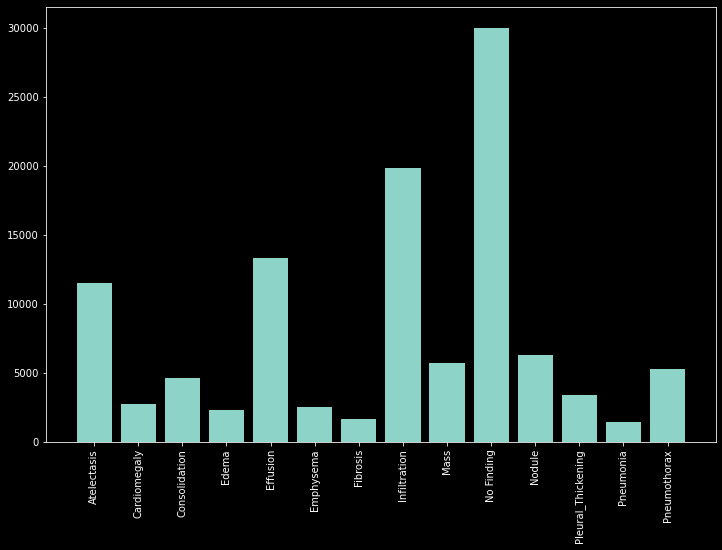

In [17]:
# See the new labels and their distribution in the clean_df
n_labels = clean_df.columns.to_list()[4:]
n_counts = pd.Series({l : clean_df[l].sum() for l in n_labels})
print(n_counts)
plot_distribution(n_counts)

No Finding is good for Sorting but an extra feature means more computational power required. Thus we need to delete it :( but after the train test split is done 

At this point, we have 80K images that are slated to be tested. We are going to train with 50K images:
- 30K Training 
- 10K Testing
- 10K Validation 

## Instantiate a `Train_Test_Split` to Sample Desired Data Size 

- Split between Training and validation set and split validation set into validation and test set. 

- stratify the finding labels column by only letting it see the first four letters of the labels. 

- This ensures that we are only looking at the first finding and the minimum letters for the first finding is 4 as it could be either Edema or Mass. Otherwise, train_test_split will throw an error as it considers each individual set of strings as its own unique identifier. 

- Minimum sample for train_test_split stratify should be greater than 1. 

In [20]:
# Instantiate a Train_Test_Split and split the data into train and test sets. 
# Stratify the sampling to ensure distributions are maintained. 
# Train_size and Test_size must be defined using integers to ensure the data size is correct. 

train_df, val_test_df = train_test_split(clean_df, 
    stratify = clean_df["Finding Labels"].map((lambda x: x[:4])) , 
        random_state = 100, train_size = 30000, test_size = 20000)

In [21]:
# Instantiate a Train_Test_Split and split the data into test and validation sets
# Stratify the sampling to ensure distributions are maintained. 
# Train_size and Test_size must be defined using integers to ensure the data size is correct. 

val_df, test_df = train_test_split(val_test_df, 
    stratify = val_test_df["Finding Labels"].map((lambda x: x[:4])), 
        random_state = 100, train_size = 0.5)

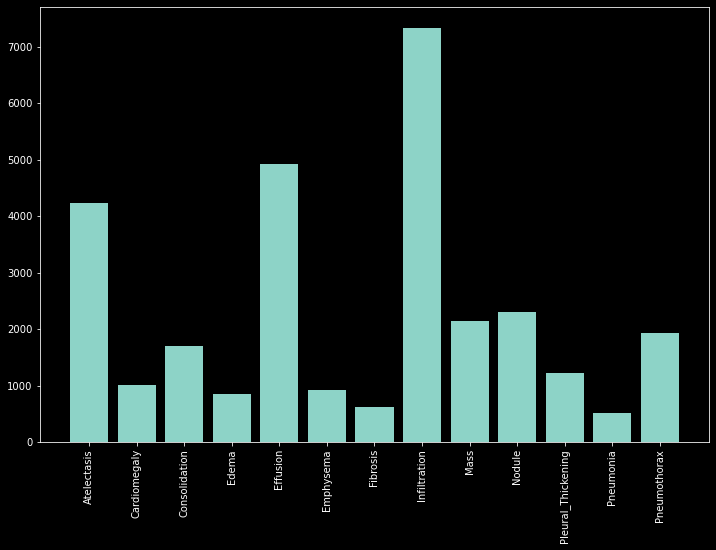

In [22]:
# Check to see the distribution of the disease labels in the sample data

train_dis = pd.Series({l : train_df[l].sum() for l in n_labels})
plot_distribution(train_dis)

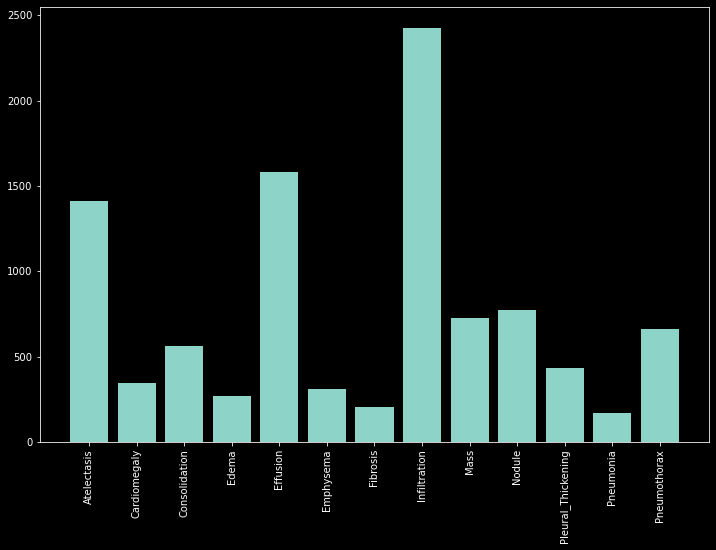

In [23]:
# Check to see the distribution of the disease labels in the sample data

val_dis = pd.Series({l : val_df[l].sum() for l in n_labels})
plot_distribution(val_dis)

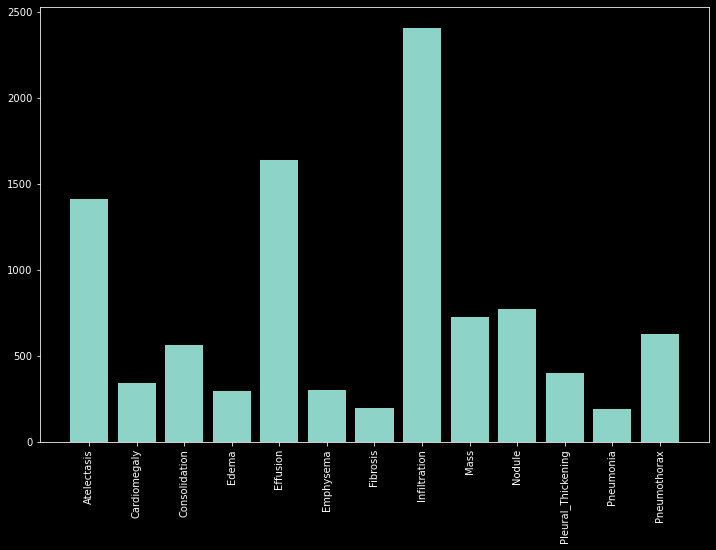

In [24]:
# Check to see the distribution of the disease labels in the sample data

test_dis = pd.Series({l : test_df[l].sum() for l in n_labels})
plot_distribution(test_dis)

### Preprocess Image Data Using Image DataGenerators 

- Image data is preprocessed and fed into the model in batches by iterating through the directories where the images are located. 

- Ideally The images should be sorted into spearate folders but due to the high volume of images to sort, we can use the flow_from_dataframe() function instead and used the defined paths in our df.

- Images are randomly modified by flipping horizontally, rotating, slanting, shifiting etc to ensure randomization to prevent model from focusing on the wrong features during convolutions. 

- Images are 1024 x 1024; they are resized to 224 x 224 this is the standard size for the google image classifier MobileNetV2. 

- There are 3 generators. One for training data that will shuffle the imges, the testing and the validation datas images will not be shuffled. the testing data do not have labels since they will be predicted by the model. 

In [25]:
# Define image size and instantiate an Image Data Generator and define its parameters
# The parameters focus on random modifications to the images to ensure the model doesn't focus on the wrong features
# Since the image is in greyscale we don't have to worry about messing with the parameters that deal with color/ brightness
# Just the physical modifications of the images themselves. 
# We have a lot of leeway with the images since the features should be localized towards the middle most of the time.
# Don't go too wild with the modifications and shift out of range/ focus of the features.

# Image size is based on the input shape for 
image_size = (224, 224)

imdg = ImageDataGenerator(
    rescale = 1/255,
    samplewise_center = True, # Set each sample mean to 0.  
    samplewise_std_normalization = True, # Divide each input by its std. 
    horizontal_flip = True, # Flips samples horizontally randomly to prevent over fitting over wrong features
    vertical_flip = False, 
    width_shift_range=0.1, # Define how the images should be randomly shifted when fed, 10% of image 
    height_shift_range= 0.05, # Define how the images should be  randomly shifted when fed, 5% of image
    shear_range = 0.1, # slants the images in a certain degree based on the value.
    zoom_range=0.10, # magnify the images randomly by 10% 
    rotation_range= 3, # rotate the images by 10  
    fill_mode = 'reflect' # if images have empty values due to modifications, reflect the image. 
)

In [26]:
# Define the generators for each of the dataframes
train_generator = imdg.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col= "Labels List",
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    classes = labels,
    shuffle=True,
    seed=10,
)
val_generator = imdg.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="Labels List",
    target_size=image_size,
    batch_size= 256,
    class_mode='categorical', 
    classes = labels,
    shuffle=False,
    seed=10,
)

test_generator = imdg.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    target_size=image_size,
    batch_size= 10000,
    class_mode= None,
    shuffle=False,
    seed=10,
)

Found 30000 validated image filenames belonging to 15 classes.
Found 10000 validated image filenames belonging to 15 classes.
Found 10000 validated image filenames.


### Train the Model

- Visualize some of the images that are being fed in batches to make adjustments if they look really wonky and disrupt sample viability. 

- The model is based off of an online tutorial blog by [Vijayabhaskar J](https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24). The model has two iterations of a double convolutional layer with a maxpool layer that has relu activation functions. The machine will convolve across the image based on the dimensions specified and then the results will be pooled and sent to the next layer. The results are tensors which are just arrays of dot products. 

- The next layer is the flatten layer that will reduce the dimensions of the tensors so that the regular neural neurons in the single dense hidden layer can process them. Then the data will be categorized in the output layer with a sigmoid function since this is a classification model. Relu functions througout the layers prevent the values from becoming having too much range and allows the model to process non-linear patters. 

- Drop out layers are sandwiched between each major layer to ensure that when the model gets optimized, neurons that do not provide useful information are discarded to make the model more efficient. 

- The tried and true adam optimizer along with binary-crossentropy and accuracy metrics will be used to compile this classification model. 

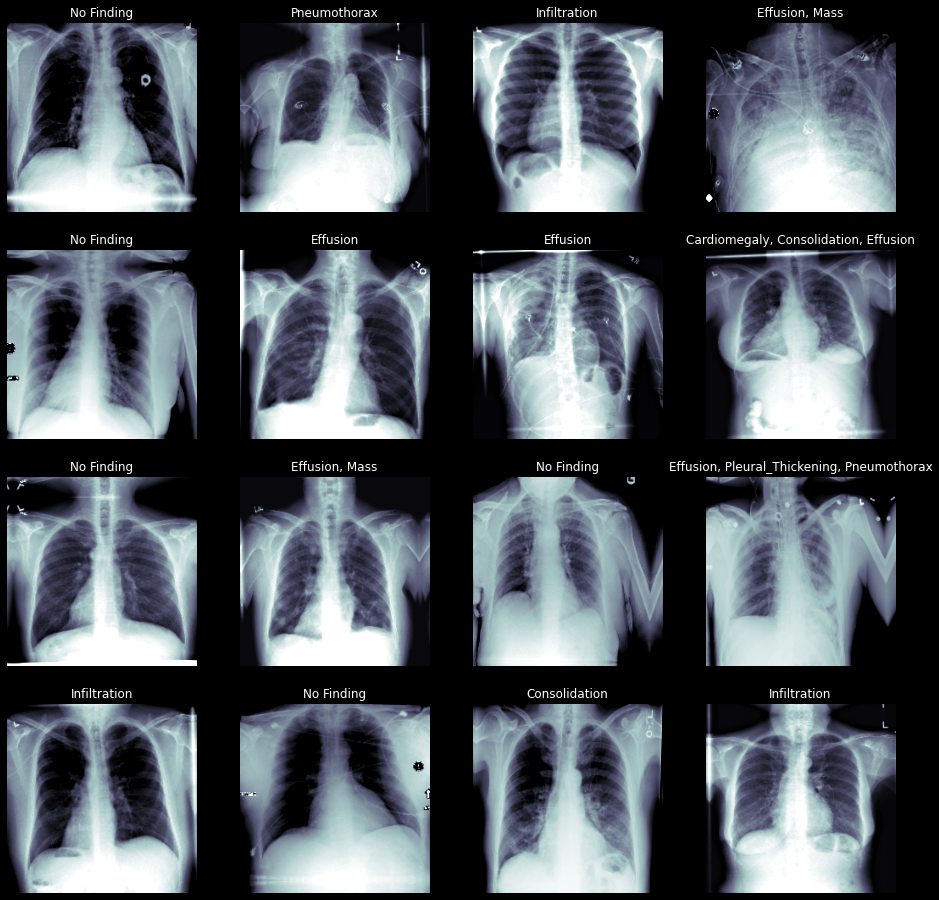

In [27]:
# Sample the images to be fed from the training set and visuzalize them
# Adjust the ImageData Generator accordingly based on output variability. 

t_x, t_y = next(train_generator)
# instantiate a figure and axes to plug images into 
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# Define how each of the images will be plotted each image will have its label associated so importnat to zip
# Flatten the images to reduce dimensionality
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    # Display the image using imshow along a new axies instance across all dimensions 
    # Define the color map for bones and xrays using cmap and let it cover over 150% using vmin/vmax 
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    # Loop through the labels in the target output using the labels and plot them accordingly. 
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    # Turn off the axies ticks so that the images aren't cluttered. 
    c_ax.axis('off')

In [28]:
# Differential Model Incorporating Mobile Net V 2


In [29]:
# Build Model layers alternate between convolving and pooling the convolutional data.

model = Sequential()

# first iteration of convolution/pooling layer with a relu function activation. 
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(224,224,3)))
model.add(Activation('relu')) # We want the resulting convolved outputs to be positive values only. 
# second conv layer with relu function. 
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding first drop out layer to prevent overfitting. 25% of beurons will drop out. 
model.add(Dropout(0.25))

# Second iteration of the conv/pool layer. 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding second drop out layer to prevent overfitting. 
model.add(Dropout(0.25))

# Flatten the outputs to help with categorization
model.add(Flatten())

# Final hidden layer with 512 neurons since this keeps popping up in my searches. 
model.add(Dense(512))
model.add(Activation('relu'))

# Drop out to reduce if necessary 
model.add(Dropout(0.5))

# Final categorization output layer with 14 label categories. 
model.add(Dense(15, activation='sigmoid'))

# Compile the model 
model.compile(optimizer ='adam',loss="binary_crossentropy",metrics=["accuracy"])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                        

In [31]:
# Save checkpoints

weights = "weights/{}_weights.best/hdf5".format("modelalpha")

checkpoint = ModelCheckpoint(
    weights, monitor="val_loss", 
    verbose = 1, 
    save_best_only = True,
    mode = "min", 
    save_weights_only = True  
)


In [32]:
# Fit and train use fit_generator() to fit in the batches of images 

model.fit_generator(
    train_generator, 
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    validation_data = val_generator,
    validation_steps = val_generator.n//val_generator.batch_size,
    epochs = 50,
    callbacks = checkpoint 
)

c:\Users\Fabalin\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
 11/937 [..............................] - ETA: 32:15 - loss: 0.8272 - accuracy: 0.2262

KeyboardInterrupt: 

### Output Compute 

- Test data is used to make the model provide predicitions and the accuracy of the model is evaluated using the AUC/ROC curve. 

- Higher AUC, the better the model is at predicting a specific class label. The ROC Curve displays the model's classification accuracy across each label based on the true positives and false positives. Ideally, the curves for all labels should be veering towards the top left corner since we want to maximize the true positive and minimize the false positive values. 

In [ ]:
# Predict the Test Dataset 
test_generator.reset()
pred_y = model.predict(
    test_generator, 
    steps = test_generator.n//test_generator.batch_size,
    verbose=1)

1/1 [==============================] - 5s 5s/step


In [ ]:
# Transform the labels into a list of binaries
test_Y = test_df.apply(lambda x: [x[n_labels].values], axis = 1).map(lambda x: x[0])

# See the average distribution of the test set 

for c_label, s_count in zip(n_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 9.33%
Cardiomegaly: 1.33%
Consolidation: 8.00%
Edema: 4.00%
Effusion: 12.00%
Emphysema: 1.33%
Fibrosis: 1.33%
Hernia: 0.00%
Infiltration: 18.67%
Mass: 4.00%
Nodule: 4.00%
Pleural_Thickening: 1.33%
Pneumonia: 1.33%
Pneumothorax: 5.33%


In [ ]:
# Transform the binarized list of labels to a numpy array or else a for loop will not be able to index well
nptest_Y = test_df[n_labels].to_numpy(dtype = int)
nptest_Y.shape


(75, 14)

c:\Users\Fabalin\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


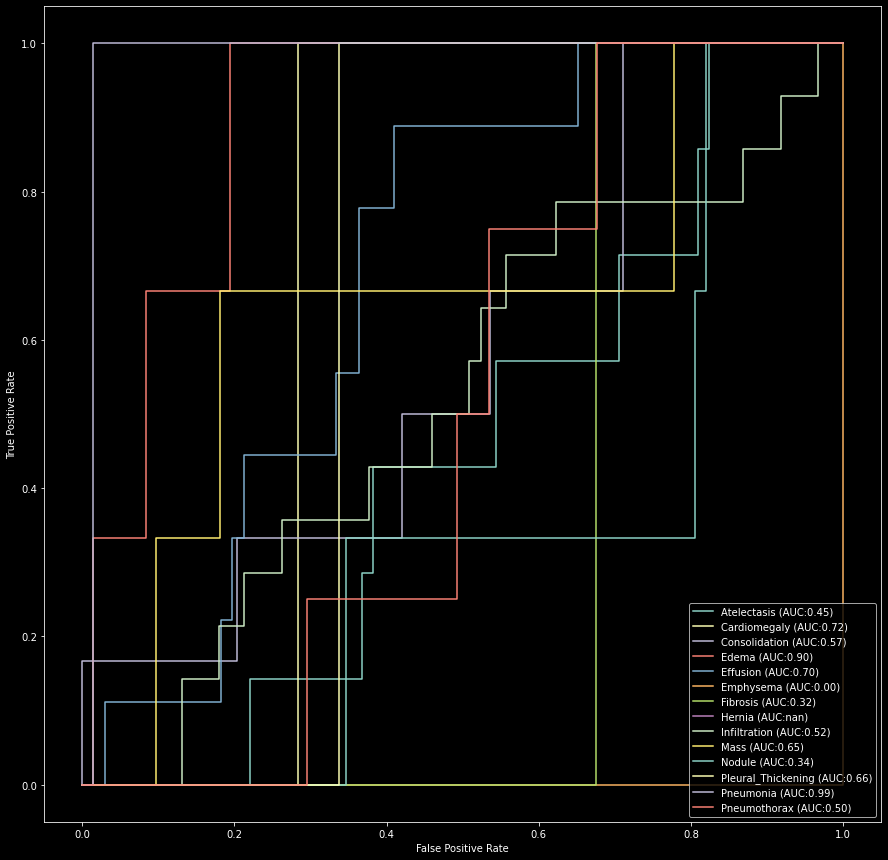

In [ ]:
# Create an AUC / ROC curve 
fig, c_ax = plt.subplots(1,1, figsize = (15, 15))

# Loop through all the labels and get the index and values. 
for (idx, c_label) in enumerate(n_labels):
    # create variables for the roc curve based on its output.
    #The for loop loops through all the values in the list of binarized labels based on index via column of the labels
    fpr, tpr, thresholds = roc_curve(nptest_Y[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('alpha_rev_50epochs.png')

In [ ]:
# See Predictions greater than 20% for the provisional model and save to csv
predictions = (pred_y > 0.2).astype(int)
columns=labels
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_df["Image Index"].tolist()
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv('alpha_rev_predictions.csv')

print(results)

           Filenames  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0   00019522_009.png            1             0              0      0   
1   00025039_000.png            0             0              0      0   
2   00003906_000.png            0             0              0      0   
3   00002437_004.png            1             0              0      0   
4   00005335_001.png            1             0              0      0   
..               ...          ...           ...            ...    ...   
70  00011548_005.png            1             0              0      0   
71  00026412_011.png            1             0              0      0   
72  00005138_000.png            1             0              0      0   
73  00000324_001.png            1             0              0      0   
74  00028589_002.png            0             0              0      0   

    Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
0          0          0         0       0         